# You may use this as a template for your code and code report. If you do, you MUST remove Markdown cells that were not authored by you.

## FIXME: System Linearization and State Space Form

In [2]:
# Import everything we need from SymPy
import sympy as sym
import numpy as np
from sympy import Symbol, Matrix
from sympy import N as N_sympy
from sympy import simplify, sin, cos, init_printing
init_printing() # This function will make the outputs of SymPy look prettier and be easier to read

# Constants of the system
m_c = 12.0    # Mass of the chassis in kg
ixx_c = 1.0   # Roll mass moment of ineria of the chassis
iyy_c = 0.8   # Pitch mass moment of interia of the chassis
izz_c = 0.52  # Yaw mass moment of interia of the chassis

m_w = 1.2       # Mass of either wheel in kg
iaa_w = 0.0634  # Axial mass moment of interia of the wheels
itt_w = 0.0327  # Transverse mass moment of interia of the wheels
r_w = 0.325     # Radius of either wheel in meters

m = m_c + 2*m_w        # The total mass of the system
ixx = ixx_c + 2*itt_w  # The total roll mass moment of inertia of the system
iyy = iyy_c            # The total pitch mass moment of inertia of the system
izz = izz_c + 2*itt_w  # The total yaw mass moment of inertia of the system

h = 0.2   # Distance from the CoM of the chassis to wheel axle in meters
a = 0.35  # Half the distance between the wheels in meters

r_station = 20.0  # The radius of the station in meters
v_station = -0.1  # The angular velocity of the station in rad/second

# Create the system's generalized coordinates 
e_lat = Symbol('e_lat')          # The lateral error of the segbot. Positive is to the left of the target position.
phi = Symbol('phi')              # The yaw of the chassis of the segbot relative to the station. Positive is facing left.
phidot = Symbol('phidot')        # The yawing velocity of the segbot relative to the station. Positive is turning left.
v = Symbol('v')                  # The forward velocity of the segbot. Positive is moving forward.
theta = Symbol('theta')          # The pitch of the chassis of the segbot. Positive is tipped forwards.
thetadot = Symbol('thetadot')    # The pitching velocity of the segbot. Positive is tipping forward.
tau_l = Symbol('tau_l')          # The torque applied to the left wheel of the segbot. Positive moves the segbot forward.
tau_r = Symbol('tau_r')          # The torque applied to the right wheel of the segbot. Positive moves the segbot forward.

M = Matrix([[m + 2 * iaa_w / r_w**2, 0, m_c * h * cos(theta)],
            [0, (ixx + m_c * h**2) * sin(theta)**2 + izz * cos(theta)**2 + (2 * iaa_w * a**2 / r_w**2) + 2 * m_w * a**2, 0],
            [m_c * h * cos(theta), 0, iyy * m_c * h**2]])
N = Matrix([[m_c * h * (phidot**2 + thetadot**2) * sin(theta)],
            [-2 * (ixx - izz + m * h**2) * cos(theta) * sin(theta) * phidot * thetadot - m_c * h * sin(theta) * v * phidot],
            [(ixx - izz + m_c * h**2) * cos(theta) * sin(theta) * phidot**2 + m_c * 9.81 * h * sin(theta)]])
R = Matrix([[1 / r_w, 1 / r_w],
            [-a / r_w, a / r_w],
            [-1, -1]])
f_partial = simplify(M.inv() * (N + R * Matrix([[tau_l], [tau_r]])))
f = Matrix([[v * sin(phi)],
            [f_partial]])
f = simplify(f)
f


⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                -18.4325593081475⋅τₗ - 18.4325593081475⋅τᵣ - 14.377396260355⋅
⎢                ─────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                     89.85872
⎢                                                                             
⎢                                                  -1.056⋅φ̇⋅θ̇⋅sin(2⋅θ) - 2.4
⎢                                                  ───────────────────────────
⎢                                                                             
⎢                                                                          0.9
⎢                                                   

In [21]:
# FIXME: Find an equilibrium point and linearize the system into state space form

# Define the equilibrium point for linearization
equilibrium = {e_lat: 0, v: 0, phi: 0, phidot: 0,  theta: 0, thetadot: 0, tau_l: 0, tau_r: 0}

# Define the extended state vector including 'v', 'phidot', and 'thetadot'
state_vector = Matrix([e_lat, v, phi, phidot, theta, thetadot])
input_vector = Matrix([tau_l, tau_r])

# Recompute the Jacobians with respect to the extended state vector and input vector
A_jacobian_full = f.jacobian(state_vector)
B_jacobian_full = f.jacobian(input_vector)

# Add dummy rows for phidot and thetadot to A_eq and zeros to B_eq
# These rows indicate that phidot_dot = phidot and thetadot_dot = thetadot, thus forming a complete set of state equations
A_eq = A_jacobian_full.subs(equilibrium).col_join(Matrix([[0, 0, 0, 1, 0, 0],  # phidot state equation: phidot_dot = phidot
                                                          [0, 0, 0, 0, 0, 1]])) # thetadot state equation: thetadot_dot = thetadot

# Update B_eq to include dummy rows with zeros for inputs affecting phidot and thetadot
B_eq = B_jacobian_full.subs(equilibrium).col_join(Matrix([[0, 0], [0, 0]]))

# Display the updated linearized matrices
A_eq_simplified = simplify(A_eq)
B_eq_simplified = simplify(B_eq)

A_eq_simplified, B_eq_simplified

⎛⎡0  0  0  0          0          0⎤  ⎡        0                  0        ⎤⎞
⎜⎢                                ⎥  ⎢                                    ⎥⎟
⎜⎢0  0  0  0  -245.056661411115  0⎥  ⎢15.5326172644856   15.5326172644856 ⎥⎟
⎜⎢                                ⎥  ⎢                                    ⎥⎟
⎜⎢0  0  0  0          0          0⎥  ⎢-1.04916430028235  1.04916430028235 ⎥⎟
⎜⎢                                ⎥, ⎢                                    ⎥⎟
⎜⎢0  0  0  0  1592.91663381947   0⎥  ⎢-99.6830245697014  -99.6830245697014⎥⎟
⎜⎢                                ⎥  ⎢                                    ⎥⎟
⎜⎢0  0  0  1          0          0⎥  ⎢        0                  0        ⎥⎟
⎜⎢                                ⎥  ⎢                                    ⎥⎟
⎝⎣0  0  0  0          0          1⎦  ⎣        0                  0        ⎦⎠

## Check Controllability

In [22]:
import numpy as np
from sympy import Matrix

# Convert SymPy matrices to NumPy for numerical computations
A_num = np.array(A_eq).astype(np.float64)
B_num = np.array(B_eq).astype(np.float64)

# Define a function to compute the controllability matrix
def controllability_matrix(A, B):
    n = A.shape[0]
    controllability = B
    for i in range(1, n):
        controllability = np.hstack((controllability, np.linalg.matrix_power(A, i) @ B))
    return controllability

# Compute the controllability matrix
Ctrb = controllability_matrix(A_num, B_num)

# Compute its rank
rank = np.linalg.matrix_rank(Ctrb)

print(f"Controllability Matrix Rank: {rank} / {A_num.shape[0]}")

Controllability Matrix Rank: 4 / 6


In [26]:
np.linalg.eig(A_num)

EigResult(eigenvalues=array([  0.        ,  39.91135971, -39.91135971,   0.        ,
         0.        ,   1.        ]), eigenvectors=array([[ 0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         0.        ],
       [ 1.        , -0.15200607,  0.15200607,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [ 0.        ,  0.98806946, -0.98806946,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.0247566 ,  0.0247566 ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ]]))

## Gain Selection and Controller Design

In [30]:
# FIXME: Select a set of control and observer gains. Ensure the resultant system is stable. Implement your controller below.
import numpy as np
from scipy.linalg import solve_continuous_are

# Convert the symbolic A and B to numpy
A_eq_num = np.array(A_eq_simplified).astype(np.float64)
B_eq_num = np.array(B_eq_simplified).astype(np.float64)

# Define the Q and R matrices for LQR
Q = np.diag([-1, 1, -1, 1, -1, -1])
R = np.array([[1, 2], [2, 1]])

# Solve for gain matrix
P = solve_continuous_are(A_eq_num, B_eq_num, Q, R)

#Calculate the LQR gain matrix K
K = np.linalg.inv(R) @ B_eq_num.T @ P
K

LinAlgError: Failed to find a finite solution.

## Feedback Controller and Gains

In [4]:
class FeedbackController:
    def __init__(self, Kp, Ki, Kd, setpoint=0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        self.integral = 0
        self.prev_error = 0

    def update(self, current_value, dt):
        error = self.setpoint - current_value
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt if dt > 0 else 0
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
        return output

In [113]:
# Necessary imports
from scipy.linalg import solve_continuous_are
import numpy as np

# Controller class
class Controller():
    def __init__(self):

        self.pid_elat = FeedbackController(Kp=2, Ki=0.5, Kd=0.1)     # Lateral error control
        self.pid_phi = FeedbackController(Kp=3.0, Ki=1.0, Kd=0.25)      # Heading error control
        self.pid_phidot = FeedbackController(Kp=0.5, Ki=0.025, Kd=0.001)   # Yaw velocity control
        self.pid_theta = FeedbackController(Kp=30, Ki=1.25, Kd=0.25)   # Pitch angle control

    def reset(self):
        pass        

    def run(self, **kwargs):
        # Extract the system states
        e_lat = kwargs["e_lat"]         # Lateral error
        phi = kwargs["phi"]             # Heading error (yaw)
        phidot = kwargs["phidot"]       # Yaw velocity
        theta = kwargs["theta"]         # Pitch angle
        dt = 0.0001              # Time step

        # Update PID controllers for e_lat, phi, phidot, and theta
        pid_elat_output = self.pid_elat.update(e_lat, dt)
        pid_phi_output = self.pid_phi.update(phi, dt)
        pid_phidot_output = self.pid_phidot.update(phidot, dt)
        pid_theta_output = self.pid_theta.update(theta, dt)

        # Combine the PID outputs to calculate the control effort (wheel torques)
        # Adjust to ensure that lateral error correction drives movement towards the center of the ring
        left_torque = pid_elat_output + pid_theta_output + pid_phidot_output + pid_phi_output
        right_torque = -pid_elat_output + pid_theta_output - pid_phidot_output - pid_phi_output

        # Return the control inputs (left and right wheel torques)
        inputs = [-left_torque, -right_torque]
        return inputs

In [114]:
# Create an instance of our Controller class
controller = Controller()

## Running the Simulation

Before we run the simulation, we must first import the simulation module and then create an instance of the simulator. This is done below:

In [115]:
# Import the segbot project. This module is used to simulate, render, and plot a segbot dynamic system
import ae353_segbot

In [116]:
sim = ae353_segbot.Segbot_sim(use_keyboard=True,
                              visualization=True,
                              animation=False,
                              bumpy=False)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7012/static/


In [117]:
# Run the simulation and collect the simulation data
data = sim.run(controller,
               max_time=None,
               initial_e_lat = 0.0,
               station_velocity = -0.1)

PRESS ENTER TO START SIMULATION.
PRESS ESC TO QUIT.
PRESS SPACE TO PAUSE/RESUME SIMULATION.
PRESS BACKSPACE TO RESET SIMULATION.
CONTINUING...
QUITTING...


## Post-processing the simulation data

In [118]:
# Import the pyplot module from the matplotlib package
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

Termination command detected. Terminating keyboard listener. Goodbye


## Pitch vs. Time with Torque vs. Time Plots

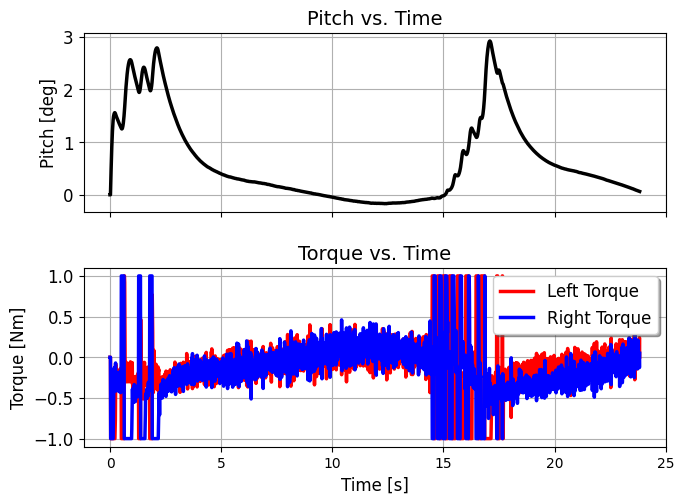

In [119]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=True)

# Create a plot of the pitch angle versus time on the first plot
axes[0].plot(data['time'], 180.*np.array(data['theta'])/np.pi, c='k', lw=2.5)
axes[0].set_ylabel("Pitch [deg]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Pitch vs. Time", fontsize=14)
axes[0].grid()

# Create a plot of the torque versus time on the second plot
axes[1].plot(data['time'], data['tau_l'], label="Left Torque", c='r', lw=2.5)
axes[1].plot(data['time'], data['tau_r'], label="Right Torque", c='b', lw=2.5)
axes[1].set_xlabel("Time [s]", fontsize=12)
axes[1].set_ylabel("Torque [Nm]", fontsize=12)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].legend(fontsize=12, shadow=True)
axes[1].set_title("Torque vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()

## Yaw Angle vs. Time Plot

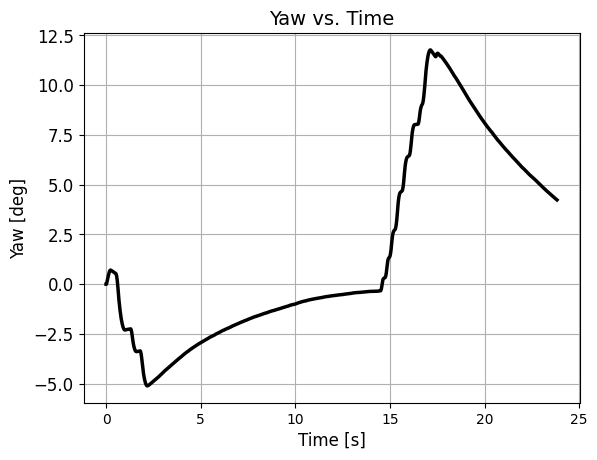

In [120]:
# Create a plot of the pitch angle versus time on the first plot
plt.plot(data['time'], 180.*np.array(data['phi'])/np.pi, c='k', lw=2.5)
plt.ylabel("Yaw [deg]", fontsize=12)
plt.xlabel("Time [s]", fontsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.title("Yaw vs. Time", fontsize=14)
plt.grid()

plt.show()

## E_lat vs. Time Plot

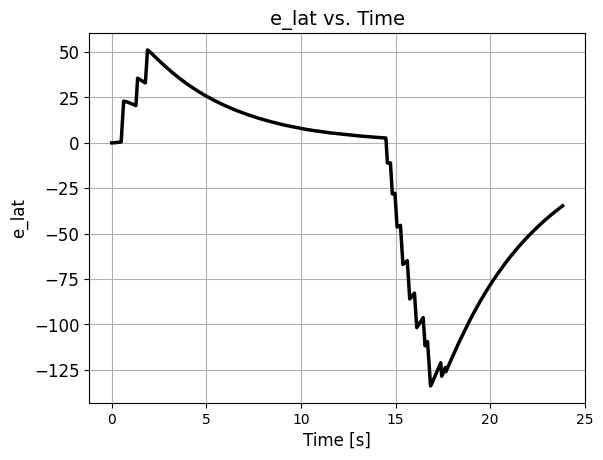

In [121]:
# Create a plot of the pitch angle versus time on the first plot
plt.plot(data['time'], 180.*np.array(data['e_lat'])/np.pi, c='k', lw=2.5)
plt.ylabel("e_lat", fontsize=12)
plt.xlabel("Time [s]", fontsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.title("e_lat vs. Time", fontsize=14)
plt.grid()

plt.show()